In [1]:
using JuMP
using SumOfSquares
using MosekTools
using LinearAlgebra
using DynamicPolynomials
using PyPlot

In [2]:
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)



function plot_vectorfield(f, limits_x=(-0.1, 1.1, 100), limits_y=(-0.1, 1.1, 100))
    x = range(limits_x[1], stop=limits_x[2], length=limits_x[3])
    y = range(limits_y[1], stop=limits_y[2], length=limits_y[3])
    xx = broadcast((x, y) -> x, x', y)
    yy = broadcast((x, y) -> y, x', y)
    fXY = broadcast(f, x', y)
    fXY_X = map(u -> u[1], fXY)
    fXY_Y = map(u -> u[2], fXY)
    PyPlot.streamplot(xx, yy, fXY_X, fXY_Y, linewidth=1)
end

function plot_box()
    PyPlot.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], "--", color=:black)
end

function plot_poly_vectorfield(p, limits_x=(-0.1, 1.1, 100), limits_y=(-0.1, 1.1, 100))
    f = (a, b) -> [p[1](a, b); p[2](a, b)]
    
    PyPlot.figure(figsize=(5, 5))
    PyPlot.xlabel("\$x_1\$")
    PyPlot.ylabel("\$x_2\$")
    plot_vectorfield(f, limits_x, limits_y)
    PyPlot.xlim(-.1, 1.1)
    PyPlot.ylim(-.1, 1.1)
    PyPlot.xticks([0, 1])
    PyPlot.yticks([0, 1])
    plot_box()
    PyPlot.plot(data_x1, data_x2, color=:red, )
    PyPlot.scatter(data_x1, data_x2, color=:red, s=50)
end

plot_poly_vectorfield (generic function with 3 methods)

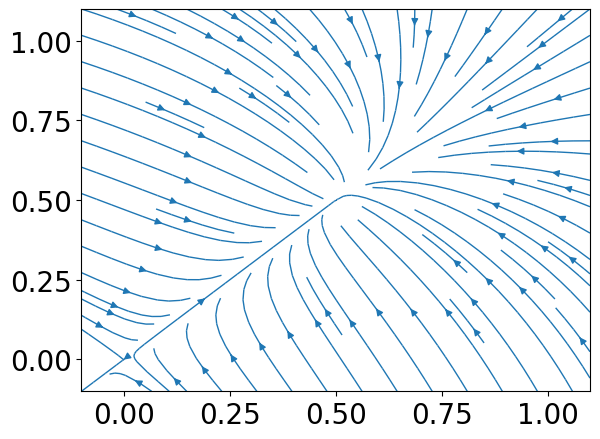

PyObject <matplotlib.streamplot.StreamplotSet object at 0x7fa4c2f96eb0>

In [3]:
a1, b1, a2, b2, c1, c2 = [.05 .1 .05 .1 1. 1.]
data_x = [0.7 0.6743 0.651733 0.631992 0.614775 0.599795 0.586786 0.575503 0.565731 0.557274 0.549955 0.543627 0.538154 0.533421 0.529324 0.525778 0.522708 0.520048 0.517738 0.515732; 0.3 0.332724 0.360048 0.382911 0.402075 0.418161 0.431681 0.443055 0.452628 0.460689 0.46748 0.473199 0.478011 0.482062 0.485469 0.488331 0.490729 0.492736 0.494415 0.495815]
data_y = [-0.0259321 -0.0229135 -0.0199887 -0.0175017 -0.0153012 -0.0133236 -0.0114618 -0.0100023 -0.00879107 -0.00724013 -0.00647079 -0.00547157 -0.00480303 -0.00421488 -0.00358632 -0.00298889 -0.00265446 -0.00228428 -0.00204884 -0.00161675; 0.0340828 0.0283447 0.0237351 0.0198431 0.0168126 0.013914 0.0118452 0.00988082 0.00808706 0.00704187 0.00585207 0.00496953 0.00420161 0.00357221 0.00288563 0.00252677 0.00205396 0.00179401 0.00127819 0.00135135]


data_x1 = data_x[1, :]
data_x2 = data_x[2, :]

data_y1 = data_y[1, :]
data_y2 = data_y[2, :]
true_vf(u1, u2) =  [-a1 * u1 + b1*(c1-u1)*u2
               -a2 * u2 + b2*(c2-u2)*u1];

plot_vectorfield(true_vf)

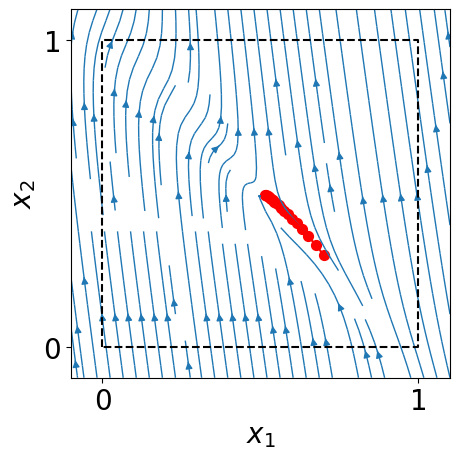

2-element Vector{Polynomial{true, Float64}}:
 -1.2879430391235336x1² - 2.3049191471554806x1x2 - 0.9998123839982164x2² + 2.3393418268379156x1 + 2.1855003027294027x2 - 1.1140283664954527
 10.295088374597544x1² + 17.138713305988436x1x2 + 7.7478485673053115x2² - 18.809980844767303x1 - 16.25705152064458x2 + 8.737154419868471

In [4]:
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

model = SOSModel(solver)
  
# Define state variables
@polyvar x1 x2

# Construct vector of monomials in (x1, x2) up to degree deg
deg = 2
z = monomials([x1, x2], 0:deg)

# Declare a polynomial whose coefficients are decision variables

@variable(model, p[1:2], Poly(z))

# Minimize least-squares error, i.e.,
# min s s.t.  ||p(data_x) - data_y|| <= s

# @variable(model, s)
# @constraint(model, [s;
#     p[1].(data_x1, data_x2) - data_y1;
#     p[2].(data_x1, data_x2) - data_y2]
#     in SecondOrderCone())
# @objective model Min s
error_term = [p[1].(data_x1, data_x2) - data_y1;
    p[2].(data_x1, data_x2) - data_y2]
@objective model Min dot(error_term, error_term)

# add_bridge ?
# Solve 
optimize!(model)

# Plot
plot_poly_vectorfield(value.(p))

value.(p)

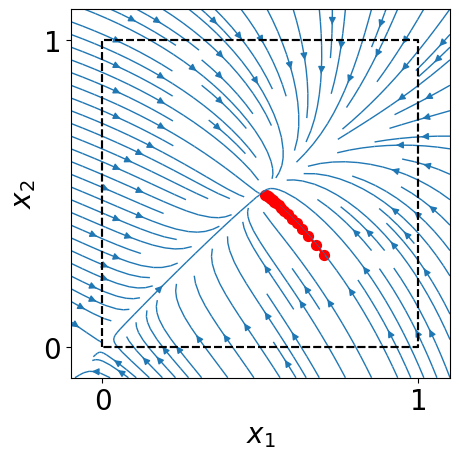

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa4aa803670>

In [10]:
deg = 2

model = SOSModel(solver)
  
# Define state variables
@polyvar x1 x2


# Construct vector of monomials in (x1, x2) up to degree 2
z = monomials([x1, x2], 0:deg)

# Declare a polynomial whose coefficients are decision variables
@variable(model, p[1:2], Poly(z))

# Minimize least-squares error, i.e.,
# min s s.t.  ||p(data_x) - data_y|| <= s

@variable(model, alpha)
@constraint(model, [alpha;
    p[1].(data_x1, data_x2) - data_y1;
    p[2].(data_x1, data_x2) - data_y2]
    in SecondOrderCone())
@objective model Min alpha

# Side information

# # Equilibrium
@constraint model p[1](0, 0) == 0
@constraint model p[2](0, 0) == 0

# invariance box [0, 1]^2
@variable(model, s[1:2], Poly([1, x1, x1^2]))
@constraint model s[1] in SOSCone()
@constraint model s[2] in SOSCone()
# polynomial identity in (**)
polynomial_identity = subs(p[2], x2=>0) - x1 * s[1] - (1-x1) * s[2]
@constraint model coefficients(polynomial_identity) .== 0

    
# coordinate monotonicity
g = [1, 1 - x1,  x2, 1 - x2, x2]
p1, p2 = p
@variable(model, σ[1:2, 1:size(g,1)], Poly(monomials([x1, x2], 0:2)))
@constraint model σ .>= 0
@constraint model vcat(coefficients.([differentiate(p1, x2), differentiate(p2, x1)] .- σ * g)...) .== 0


# Solve 
optimize!(model)

# Plot
plot_poly_vectorfield(value.(p))
plot_box()

In [12]:
round.(value.(p), digits=2)

2-element Vector{Polynomial{true, Float64}}:
 0.04x1² - 0.1x1x2 - 0.01x2² - 0.09x1 + 0.12x2
 -0.1x1x2 + 0.1x1 - 0.05x2

In [138]:
subs(p[1], x2=>0)

(noname)x1³ + (noname)x1² + (noname)x1 + (noname)

In [ ]:
;pwd